Import trick

In [157]:
import sys
sys.path.insert(0, '..')

In [158]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import numpy

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

# the real world
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
from astropy.nddata import Cutout2D

import pandas as pd

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

data

In [159]:
ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname_095 = ddir + 'HST/N43CA5020/n43ca5020_mos.fits'
fname_108 = ddir + 'HST/N43C03020/n43c03020_mos.fits'
fname_187 = ddir + 'HST/N43C03010/n43c03010_mos.fits'
fname_190 = ddir + 'HST/N43CA5010/n43ca5010_mos.fits'


wid = 64

exposure_095 = exposure_from_file(fname_095, SinglePointFit(), wid)
exposure_108 = exposure_from_file(fname_108, SinglePointFit(), wid)
exposure_187 = exposure_from_file(fname_187, SinglePointFit(), wid)
exposure_190 = exposure_from_file(fname_190, SinglePointFit(), wid)

exposures_s = [exposure_095, exposure_190]#exposure_108, exposure_187, exposure_190]

exposure_095 = exposure_from_file(fname_095, BinaryFit(), wid)
exposure_108 = exposure_from_file(fname_108, BinaryFit(), wid)
exposure_187 = exposure_from_file(fname_187, BinaryFit(), wid)
exposure_190 = exposure_from_file(fname_190, BinaryFit(), wid)

exposures_b = [exposure_095, exposure_190]#exposure_108, exposure_187, exposure_190]


models

In [160]:
oversample = 3

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

params_s = {
    "fluxes": {},
    "positions": {},
    "aberrations": np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": np.asarray([-0.05, -0.05]),
    "cold_mask_rot": np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

params_b = {
    "fluxes": {},
    "positions": {},
    "contrast": {},
    "separation": dlu.arcsec2rad(0.042),
    "position_angle": 1.8607855,
    "aberrations": np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": np.asarray([-0.05, -0.05]),
    "cold_mask_rot": np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

for exp in exposures_s:
    params_s["positions"][exp.fit.get_key(exp, "fluxes")] = np.asarray([0.,0.])
    params_s["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)*0.9

for exp in exposures_b:
    params_b["positions"][exp.fit.get_key(exp, "fluxes")] = np.asarray([0.,0.])
    params_b["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)*0.9/2
    params_b["contrast"][exp.fit.get_key(exp, "fluxes")] = 0.3

def set_array(pytree):
    dtype = np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

point_model = set_array(NICMOSModel(exposures_s, params_s, optics, detector))
binary_model = set_array(NICMOSModel(exposures_b, params_b, optics, detector))

In [161]:

def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

g = 3e-2

things_single = {
    "fluxes" : opt(g*10,10),
    "positions": opt(g*1, 0),
    "cold_mask_shift": opt(g*100, 100),
    "cold_mask_rot": opt(g*100, 100),
    "aberrations": opt(g*0.06,50),
    "outer_radius": opt(g*100, 130),
    "secondary_radius": opt(g*100,130),
    "spider_width": opt(g*100,130),
}

g = 2e-2

things_binary = {
    "fluxes" : opt(g*10,10),
    "positions": opt(g*1, 0),
    "separation": opt(g*5, 20),
    "contrast": opt(g*8, 20),
    "position_angle": opt(g*1, 20),
    "cold_mask_shift": opt(g*100,100),
    "cold_mask_rot": opt(g*100,100),
    "aberrations": opt(g*1,50),
    "outer_radius": opt(g*10, 130),
    "secondary_radius": opt(g*10,130),
    "spider_width": opt(g*10,130),
}

groups_s = list(things_single.keys())
paths_s = flatten(groups_s)
optimisers_s = [things_single[i] for i in groups_s]
groups_s = [list(x) if isinstance(x, tuple) else x for x in groups_s]

groups_b = list(things_binary.keys())
paths_b = flatten(groups_b)
optimisers_b = [things_binary[i] for i in groups_b]
groups_b = [list(x) if isinstance(x, tuple) else x for x in groups_b]

In [162]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths_s)
def loss_fn_s(model,exposures):
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

@zdx.filter_jit
@zdx.filter_value_and_grad(paths_b)
def loss_fn_b(model,exposures):
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

In [163]:
print(loss_fn_s(point_model, exposures_s))
print(loss_fn_b(binary_model, exposures_b))

(Array(68976000., dtype=float32), NICMOSModel(
  params={
    'aberrations':
    f32[8],
    'cold_mask_rot':
    f32[1],
    'cold_mask_shift':
    f32[2],
    'fluxes':
    {'N43CA5010': f32[], 'N43CA5020': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {'N43CA5010': f32[2], 'N43CA5020': f32[2]},
    'secondary_radius':
    f32[],
    'spider_width':
    f32[]
  },
  filters={'F095N': None, 'F190N': None},
  optics=NICMOSOptics(
    wf_npixels=None,
    diameter=None,
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=None,
        transformation=None,
        apertures={
          'cold_mask':
          NICMOSColdMask(
            normalise=None,
            transformation=CoordTransform(
              translation=None,
              rotation=None,
              compression=None,
              shear=None
            ),
            apertures={
              'outer':
              CircularAperture(
                normalise=None,
            

In [164]:
rc = False
fishers_s = calc_fishers(point_model, exposures_s, paths_s, recalculate=rc)
lrs_s = calc_lrs(point_model, exposures_s, fishers_s, paths_s)

fishers_b = calc_fishers(binary_model, exposures_b, paths_b, recalculate=rc)
lrs_b = calc_lrs(binary_model, exposures_b, fishers_b, paths_b)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[30.453741]]
[[ 3.0617494e+21 -4.1869772e+19]
 [-4.1869931e+19  3.2036300e+21]]
[[ 2.3007081e+11 -1.7320351e+11]
 [-1.7320351e+11  2.2368780e+11]]
[[2.3507137e+11]]
[[ 5.0951569e+20  1.7908416e+20  3.4907316e+20  3.6825765e+20
   2.1293571e+20  4.8975722e+19 -7.9157308e+19  1.8762035e+20]
 [ 1.7908960e+20 -7.5821521e+19 -1.2688048e+20  3.0094168e+20
   1.9239809e+20  9.9993053e+19 -3.1833903e+19  1.5934967e+20]
 [ 3.4906964e+20 -1.2687584e+20  2.1091768e+20 -4.1974428e+20
   7.6793279e+19 -1.6649071e+19 -6.0712908e+19  5.2772455e+19]
 [ 3.6825924e+20  3.0093890e+20 -4.1974678e+20  2.4040572e+21
  -8.8191784e+19  3.1816176e+20  7.9246527e+19 -1.5016866e+20]
 [ 2.1293464e+20  1.9239494e+20  7.6792724e+19 -8.8192320e+19
   2.6847956e+21 -7.6472723e+19 -1.8334905e+20 -2.4356324e+20]
 [ 4.8977156e+19  9.9992675e+19 -1.6662165e+19  3.1815873e+20
  -7.6472494e+19  2.4527549e+21 -2.7240316e+20  5.0443443e+19]
 [-7.9154854e+19 -3.1833725e+19 -6.0714130e+19  7.9246500e+19
  -1.8334611e+20 -2.72

  0%|          | 0/8 [00:00<?, ?it/s]

[[4.474164]]
[[ 4.1462463e+21 -3.4565672e+19]
 [-3.4565646e+19  4.1647491e+21]]
[[ 3.2068280e+12 -2.4144493e+12]
 [-2.4144495e+12  3.1176977e+12]]
[[3.2715314e+12]]
[[ 2.3249409e+21  1.8893002e+20 -2.4806673e+19  8.9560007e+19
   7.9199397e+19  2.9499009e+20 -7.2403961e+17  6.0572986e+20]
 [ 1.8892868e+20  2.5396978e+21 -1.0049725e+20  3.1183806e+19
  -1.1624123e+19 -1.7720952e+20  3.3389044e+20  2.1015469e+20]
 [-2.4808485e+19 -1.0049728e+20  3.2025125e+21  4.0646460e+19
  -1.3918095e+20 -4.6892155e+20 -4.7263624e+20 -8.3084508e+19]
 [ 8.9563473e+19  3.1182950e+19  4.0650493e+19  4.8547126e+21
   2.8639490e+19  3.2275962e+20 -7.4807561e+19 -6.7451172e+20]
 [ 7.9198904e+19 -1.1624137e+19 -1.3918160e+20  2.8638513e+19
   4.9161181e+21 -4.2590933e+18 -3.3087588e+20 -6.5243268e+20]
 [ 2.9499396e+20 -1.7721191e+20 -4.6895374e+20  3.2276855e+20
  -4.2593318e+18  4.8165486e+21 -4.4079242e+20  2.1376709e+20]
 [-7.2207739e+17  3.3390061e+20 -4.7264124e+20 -7.4808176e+19
  -3.3087855e+20 -4.407

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[[30.453741]]
[[ 3.0617494e+21 -4.1869772e+19]
 [-4.1869931e+19  3.2036300e+21]]
[[6.948163e+20]]
[[34998184.]]
[[16158258.]]
[[ 2.3007081e+11 -1.7320351e+11]
 [-1.7320351e+11  2.2368780e+11]]
[[2.3507137e+11]]
[[ 5.0951569e+20  1.7908416e+20  3.4907316e+20  3.6825765e+20
   2.1293571e+20  4.8975722e+19 -7.9157308e+19  1.8762035e+20]
 [ 1.7908960e+20 -7.5821521e+19 -1.2688048e+20  3.0094168e+20
   1.9239809e+20  9.9993053e+19 -3.1833903e+19  1.5934967e+20]
 [ 3.4906964e+20 -1.2687584e+20  2.1091768e+20 -4.1974428e+20
   7.6793279e+19 -1.6649071e+19 -6.0712908e+19  5.2772455e+19]
 [ 3.6825924e+20  3.0093890e+20 -4.1974678e+20  2.4040572e+21
  -8.8191784e+19  3.1816176e+20  7.9246527e+19 -1.5016866e+20]
 [ 2.1293464e+20  1.9239494e+20  7.6792724e+19 -8.8192320e+19
   2.6847956e+21 -7.6472723e+19 -1.8334905e+20 -2.4356324e+20]
 [ 4.8977156e+19  9.9992675e+19 -1.6662165e+19  3.1815873e+20
  -7.6472494e+19  2.4527549e+21 -2.7240316e+20  5.0443443e+19]
 [-7.9154854e+19 -3.1833725e+19 -6.0714

  0%|          | 0/11 [00:00<?, ?it/s]

[[4.474164]]
[[ 4.1462463e+21 -3.4565672e+19]
 [-3.4565646e+19  4.1647491e+21]]
[[5.6552573e+20]]
[[27286516.]]
[[17439152.]]
[[ 3.2068280e+12 -2.4144493e+12]
 [-2.4144495e+12  3.1176977e+12]]
[[3.2715314e+12]]
[[ 2.3249409e+21  1.8893002e+20 -2.4806673e+19  8.9560007e+19
   7.9199397e+19  2.9499009e+20 -7.2403961e+17  6.0572986e+20]
 [ 1.8892868e+20  2.5396978e+21 -1.0049725e+20  3.1183806e+19
  -1.1624123e+19 -1.7720952e+20  3.3389044e+20  2.1015469e+20]
 [-2.4808485e+19 -1.0049728e+20  3.2025125e+21  4.0646460e+19
  -1.3918095e+20 -4.6892155e+20 -4.7263624e+20 -8.3084508e+19]
 [ 8.9563473e+19  3.1182950e+19  4.0650493e+19  4.8547126e+21
   2.8639490e+19  3.2275962e+20 -7.4807561e+19 -6.7451172e+20]
 [ 7.9198904e+19 -1.1624137e+19 -1.3918160e+20  2.8638513e+19
   4.9161181e+21 -4.2590933e+18 -3.3087588e+20 -6.5243268e+20]
 [ 2.9499396e+20 -1.7721191e+20 -4.6895374e+20  3.2276855e+20
  -4.2593318e+18  4.8165486e+21 -4.4079242e+20  2.1376709e+20]
 [-7.2207739e+17  3.3390061e+20 -4.7264

In [165]:
optim_s, opt_state_s = zdx.get_optimiser(
    point_model, groups_s, optimisers_s
)


losses_s, models_s = [], []
for i in tqdm(range(500)):
    loss, grads = loss_fn_s(point_model,exposures_s)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs_s)
    updates, opt_state_s = optim_s.update(grads, opt_state_s)
    point_model = zdx.apply_updates(point_model, updates)

    models_s.append(point_model)
    losses_s.append(loss)

optim_b, opt_state_b = zdx.get_optimiser(
    binary_model, groups_b, optimisers_b
)


losses_b, models_b = [], []
for i in tqdm(range(500)):
    loss, grads = loss_fn_b(binary_model,exposures_b)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs_b)
    updates, opt_state_b = optim_b.update(grads, opt_state_b)
    binary_model = zdx.apply_updates(binary_model, updates)

    models_b.append(binary_model)
    losses_b.append(loss)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [166]:
print(losses_s[0], losses_s[-1])
print(losses_b[0], losses_b[-1])


68976000.0 2485361.5
40884588.0 1146372.4


In [167]:
for g in groups_s:
    if type(g) == list:
        for s in g:
            print(s, point_model.get(s))
    else:
        print(g, point_model.get(g))

print()

for g in groups_b:
    if type(g) == list:
        for s in g:
            print(s, binary_model.get(s))
    else:
        print(g, binary_model.get(g))

fluxes {'N43CA5010': Array(31666.654, dtype=float32), 'N43CA5020': Array(6032.459, dtype=float32)}
positions {'N43CA5010': Array([-5.7770393e-08,  9.6474892e-08], dtype=float32), 'N43CA5020': Array([-6.7169999e-08,  1.0367034e-07], dtype=float32)}
cold_mask_shift [-0.05103377 -0.05108802]
cold_mask_rot [0.78650737]
aberrations [ 1.1986159e-09 -1.9511788e-09 -2.3421836e-09 -2.3987401e-08
  1.3865590e-08  1.0227520e-08 -3.0921044e-09  8.2493212e-09]
outer_radius 1.1237924
secondary_radius 0.46221605
spider_width 0.092132956

fluxes {'N43CA5010': Array(15805.291, dtype=float32), 'N43CA5020': Array(3294.1665, dtype=float32)}
positions {'N43CA5010': Array([4.379686e-09, 6.033451e-08], dtype=float32), 'N43CA5020': Array([-9.453422e-09,  6.962864e-08], dtype=float32)}
separation 1.8545293e-07
contrast {'N43CA5010': Array(0.0966543, dtype=float32), 'N43CA5020': Array(0.14965859, dtype=float32)}
position_angle 1.9397974
cold_mask_shift [-0.05111672 -0.05220965]
cold_mask_rot [0.7854005]
aberrat

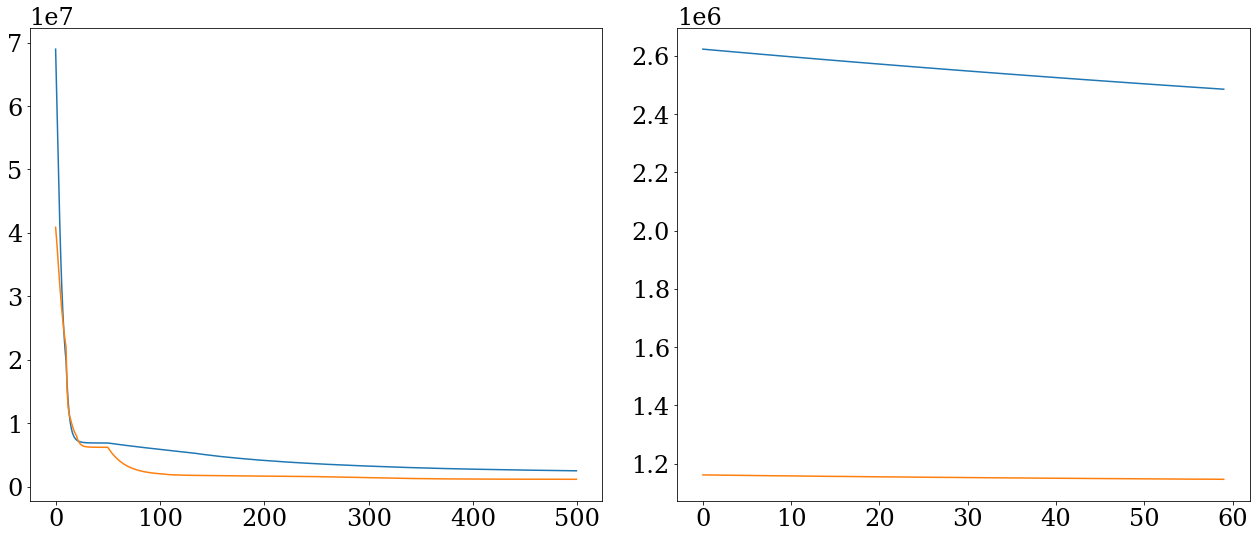

In [168]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].plot(losses_s)
axs[1].plot(losses_s[-60:])
axs[0].plot(losses_b)
axs[1].plot(losses_b[-60:])
fig.tight_layout()

32.378307 32.1777


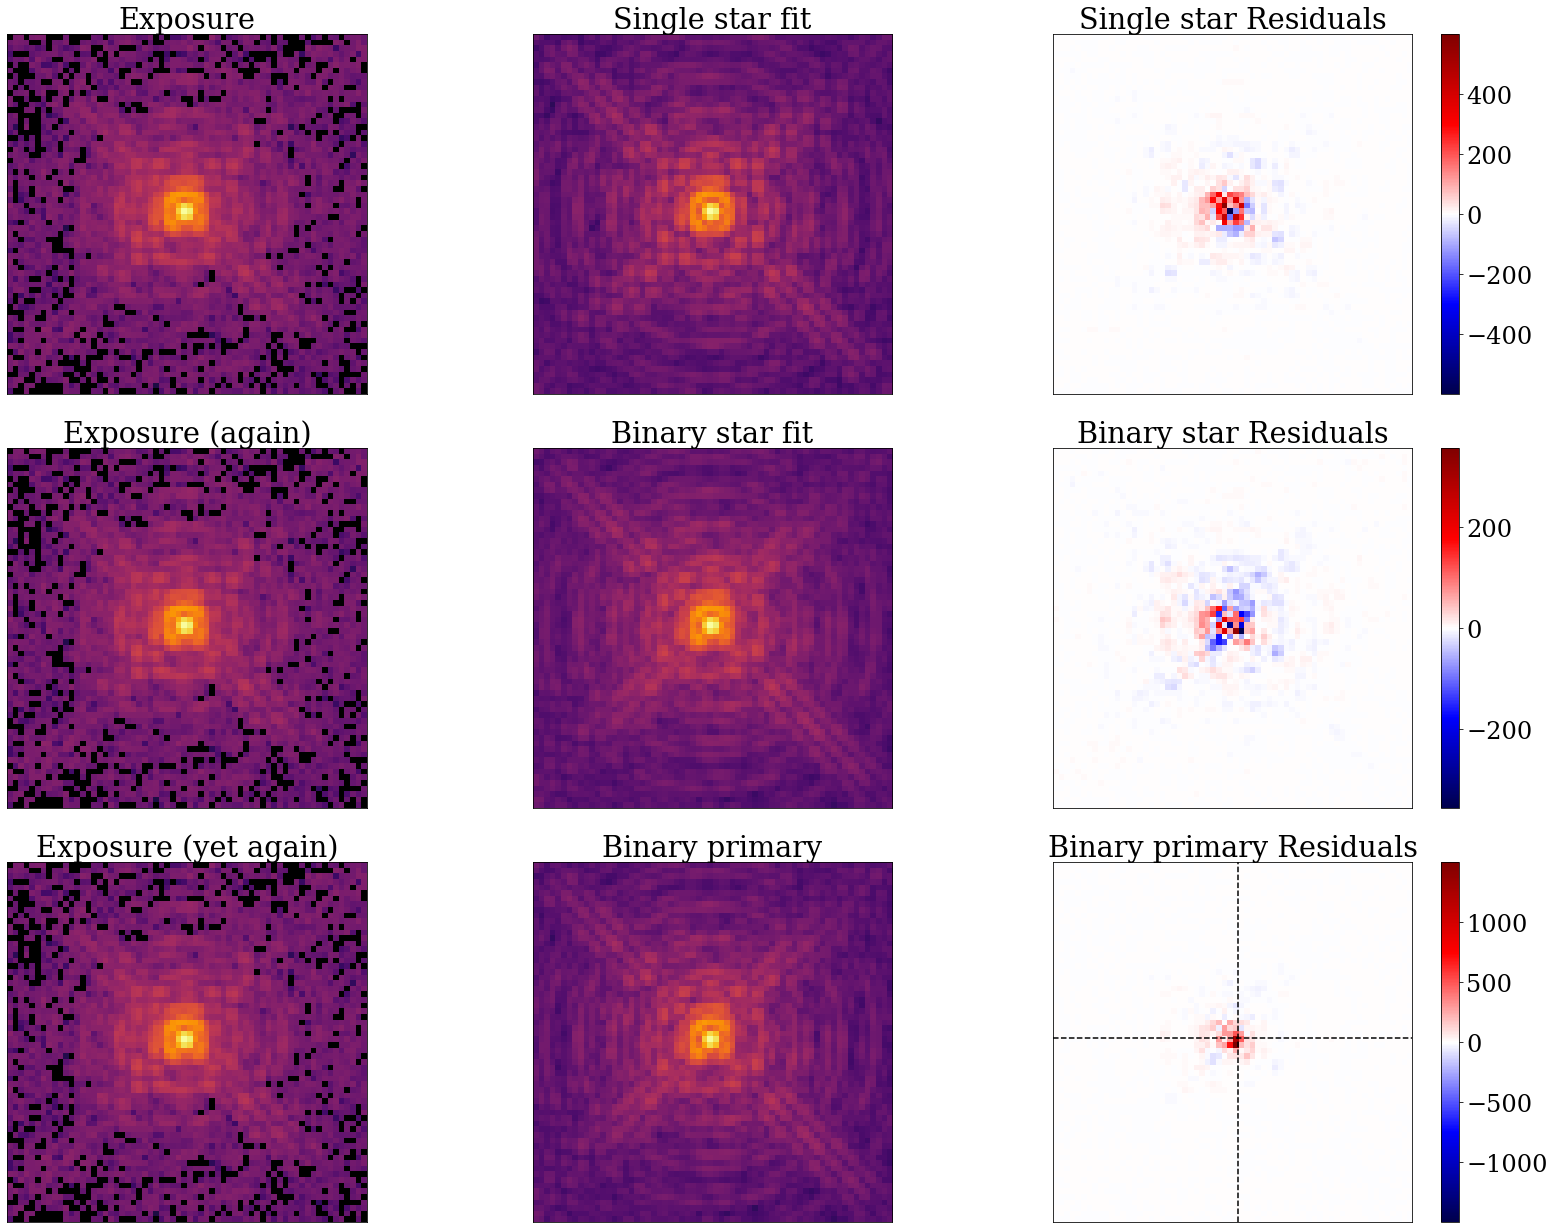

In [169]:
fig, axs = plt.subplots(3,3,figsize=(30*0.8,22*0.8))


cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)


coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exposures_s[0].data**0.125

exposure_s = exposures_s[0]
exposure_b = exposures_b[0]

point_frame = exposure_s.fit(point_model, exposure_s)**0.125
binary_frame = exposure_b.fit(binary_model, exposure_b)**0.125

single_resid = (exposure_s.data-exposure_s.fit(point_model, exposure_s))/exposure_s.err
binary_resid = (exposure_b.data-exposure_b.fit(binary_model, exposure_b))/exposure_b.err

vm = max(np.nanmax(cropped_frame),np.nanmax(point_frame), np.nanmax(binary_frame))


axs[0,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[0,1].imshow(point_frame,cmap=cmap, vmin=0, vmax=vm)
rlim = np.nanmax(np.abs(single_resid))
resid = axs[0,2].imshow(single_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[0,2])

axs[1,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[1,1].imshow(binary_frame,cmap=cmap, vmin=0, vmax=vm)

rlim = np.nanmax(np.abs(binary_resid))
resid = axs[1,2].imshow(binary_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[1,2])

f095n = np.asarray(pd.read_csv("../data/HST_NICMOS1.F095N.dat", sep=' '))
wavels = f095n[::5,0]/1e10
weights = f095n[::5,1]

positions = dlu.positions_from_sep(
        binary_model.get(exposure_b.map_param("positions")),
        binary_model.params["separation"],
        binary_model.params["position_angle"]
    )

binary_primary_source = dl.PointSource(
    spectrum=dl.Spectrum(wavels,weights),
    position = positions[1],
    flux = dlu.fluxes_from_contrast(
        binary_model.get(exposure_b.map_param("fluxes")),
        binary_model.get(exposure_b.map_param("contrast")),
    )[1]
)

binary_optics = exp.fit.update_optics(binary_model, optics)


binary_primary_system = dl.Telescope(
    binary_optics,
    #binary_model.optics,
    binary_primary_source,
    binary_model.detector
)

binary_primary_frame = binary_primary_system.model()**0.125

axs[2,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[2,1].imshow(binary_primary_frame,cmap=cmap, vmin=0, vmax=vm)

bp_resid = (exposure_b.data-binary_primary_system.model())/exposure_b.err
rlim = np.nanmax(np.abs(bp_resid))
resid = axs[2,2].imshow(bp_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[2,2])

x, y = dlu.rad2arcsec(positions[0])/0.042 + wid/2

print(x,y)

axs[2,2].axvline(x, color='k',linestyle='--')
axs[2,2].axhline(y, color='k',linestyle='--')

axs[0,0].set_title("Exposure")
axs[1,0].set_title("Exposure (again)")
axs[2,0].set_title("Exposure (yet again)")

axs[0,1].set_title("Single star fit")
axs[1,1].set_title("Binary star fit")
axs[2,1].set_title("Binary primary")

axs[0,2].set_title("Single star Residuals")
axs[1,2].set_title("Binary star Residuals")
axs[2,2].set_title("Binary primary Residuals")



for i in range(3):
    for j in range(3):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

fig.tight_layout()


8


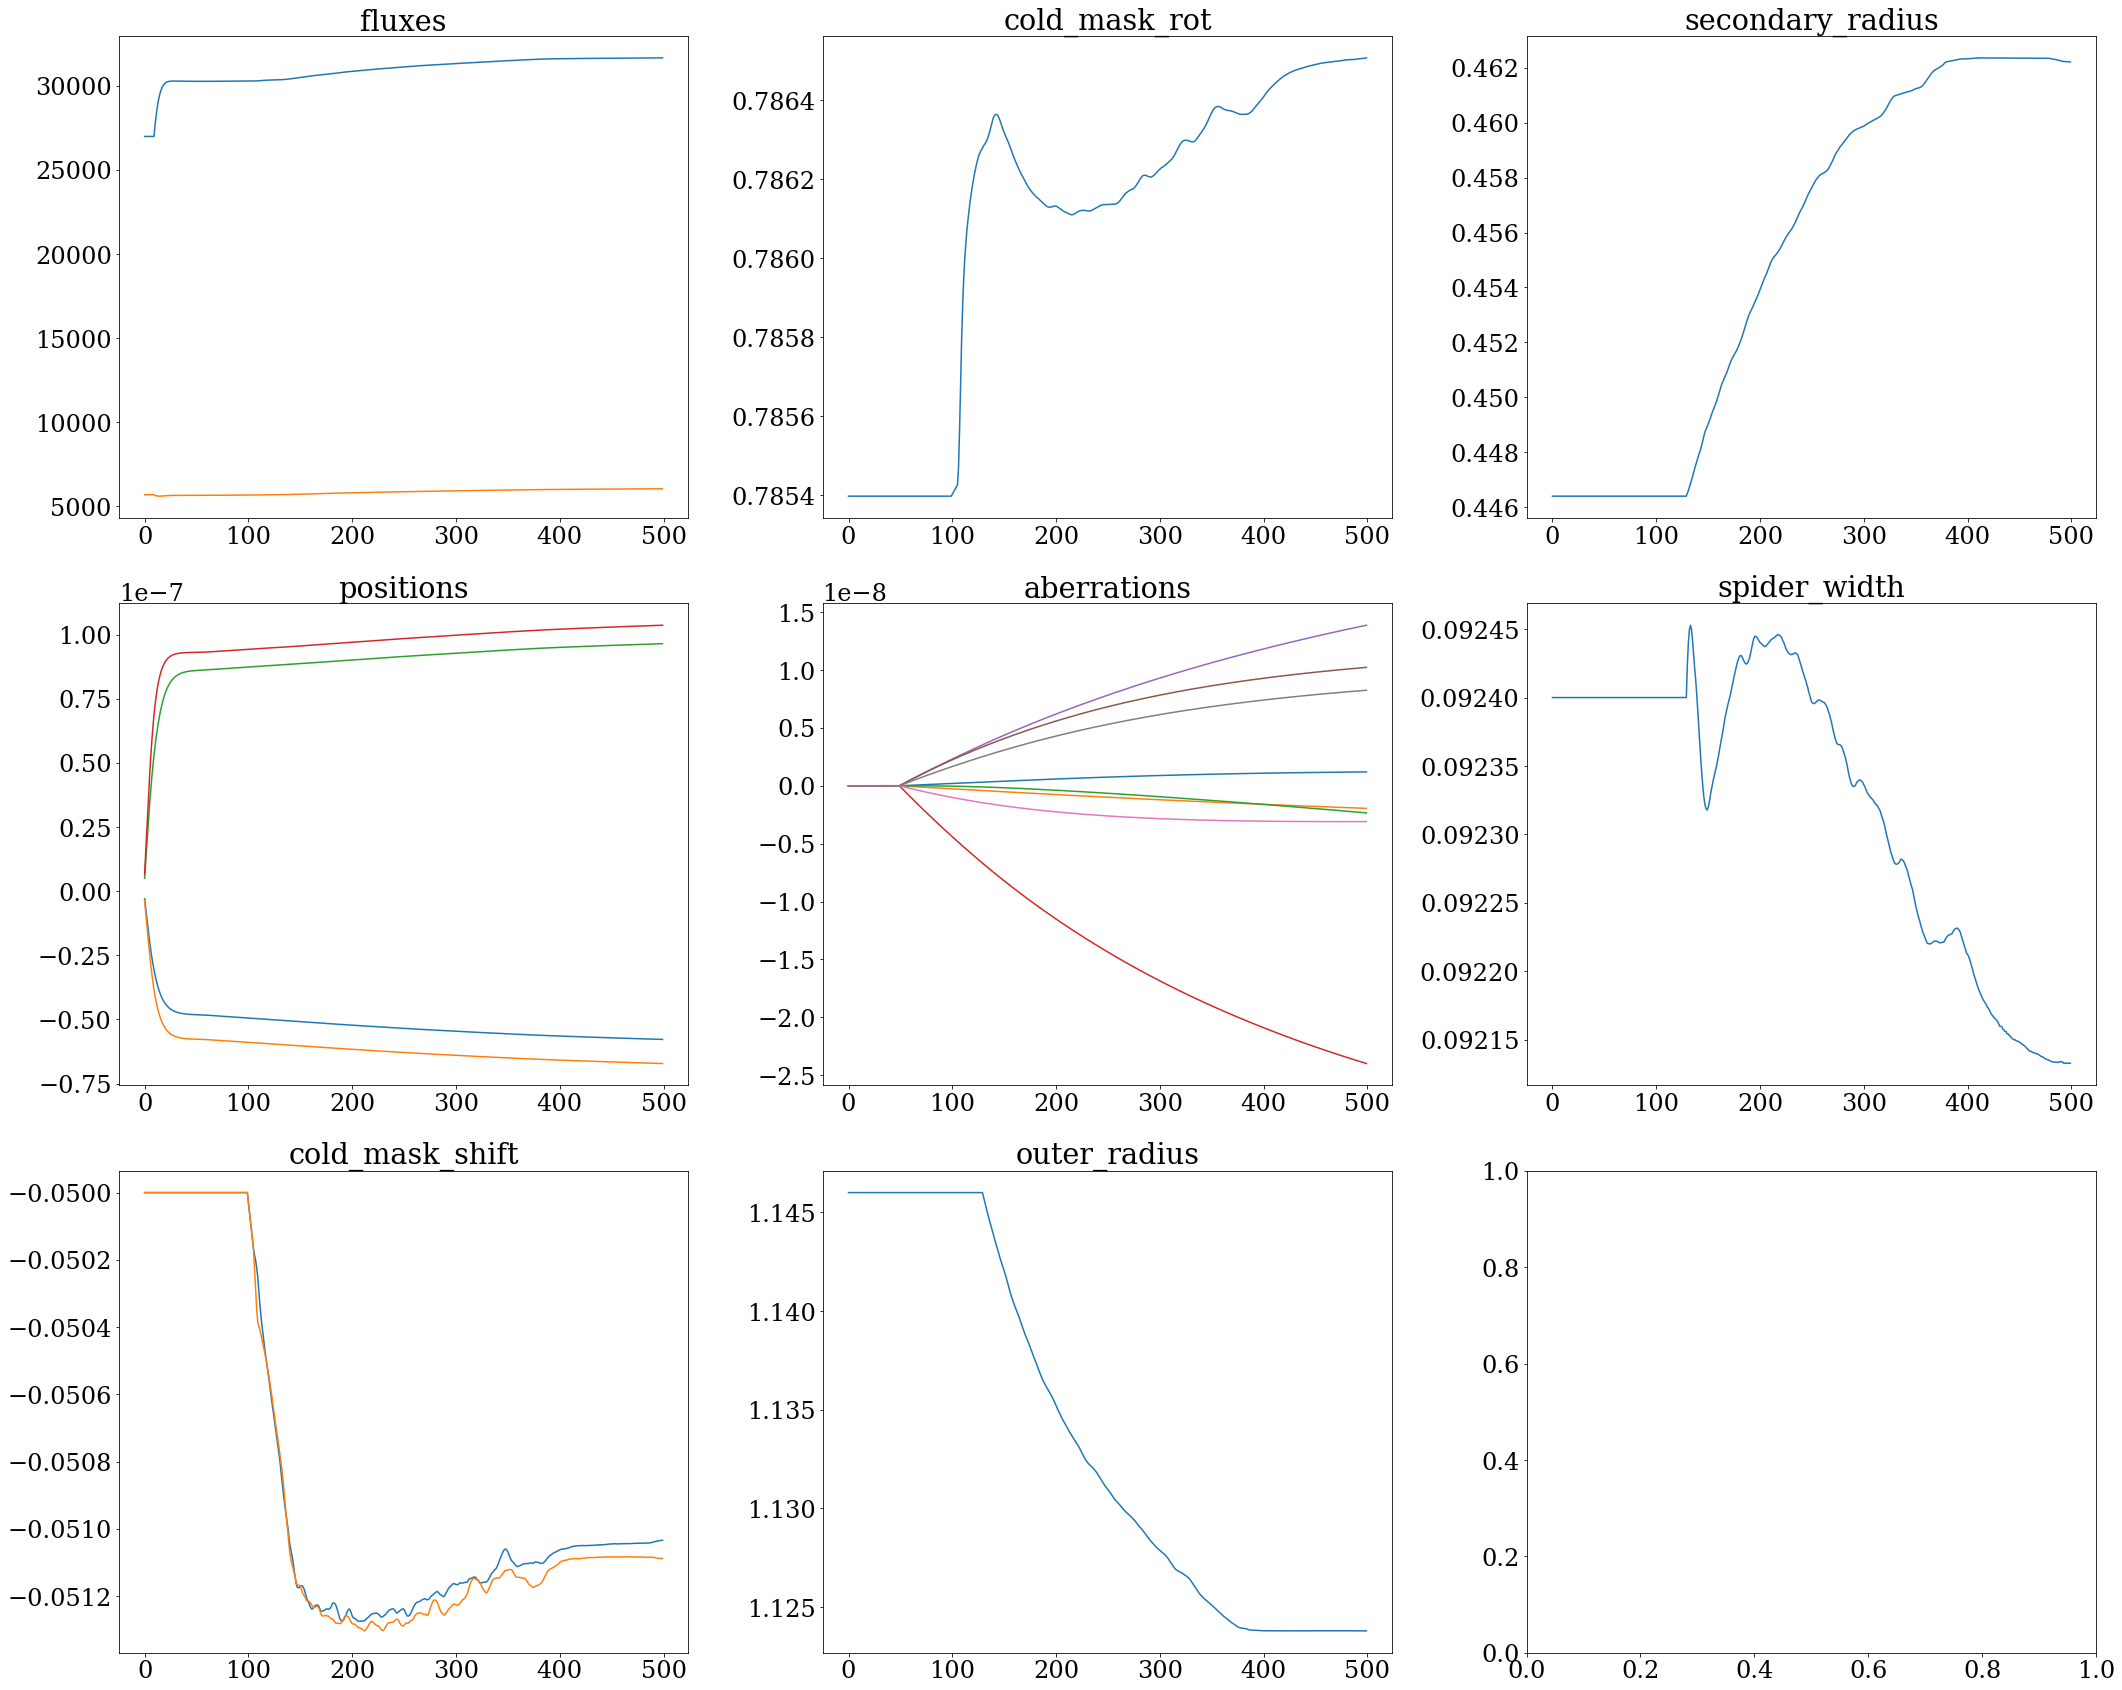

In [170]:
xw = 3
yw = int(np.ceil(len(groups_s)/xw))

print(len(groups_s))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_s):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models_s]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_s])
    
fig.tight_layout()

11


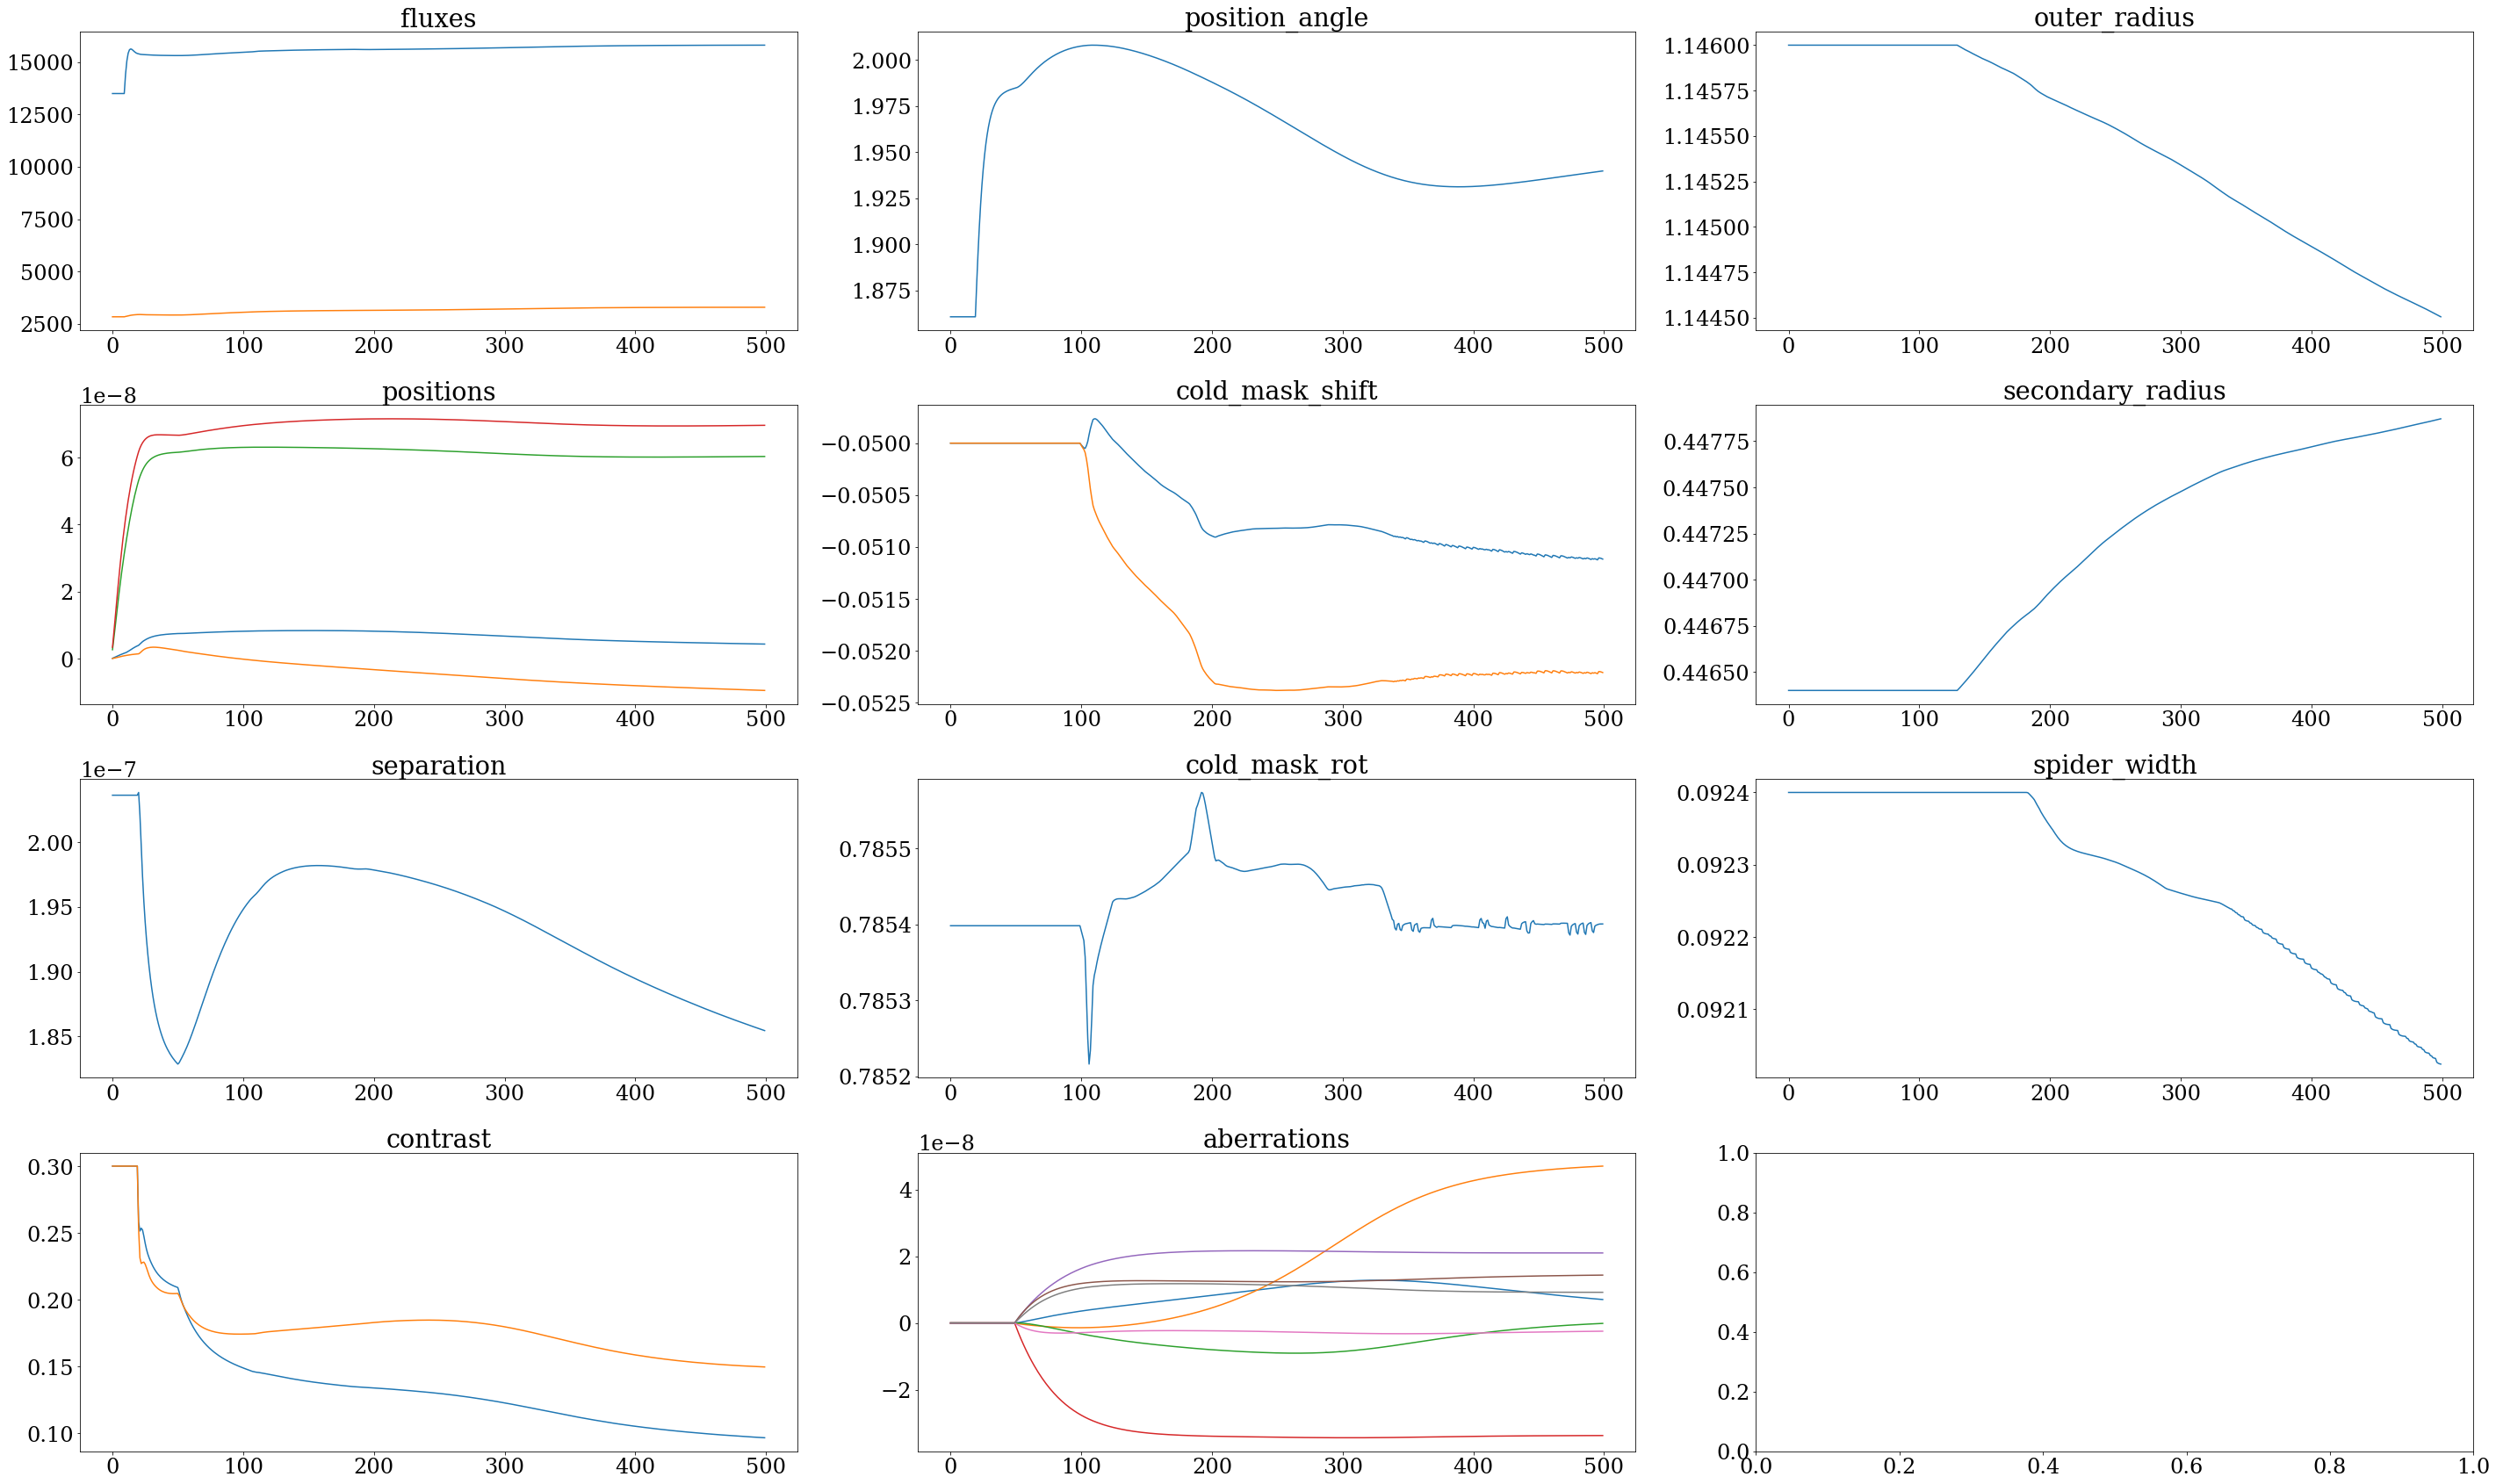

In [171]:
xw = 4
yw = int(np.ceil(len(groups_b)/xw))

print(len(groups_b))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_b):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions"]:
        #print(np.asarray(list(models_b[0].get(param).values())))
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models_b]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_b])
    
fig.tight_layout()

Evidence

In [172]:
#rc = True
#fishers_s = calc_fishers(point_model, exposures_s, paths_s, recalculate=rc, save=False)

#fishers_b = calc_fishers(binary_model, exposures_b, paths_b, recalculate=rc, save=False)


In [173]:
#fishers_s
#[[numpy.linalg.det(u.astype(np.float64)) for u in v.values()] if type(v)==dict else numpy.linalg.det(v) for v in fishers_s.values()]